# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which was the most convenient neural network environment when the work involves defining new layers some time ago. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

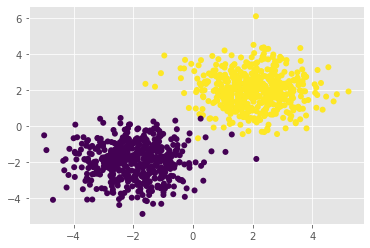

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N), np.zeros(N)])[:,None]
Y = np.hstack([Y, 1 - Y])

X = np.vstack([X1, X2])
plt.scatter(X[:,0], X[:,1], c=Y[:,0], edgecolors='none')

Define a **logistic regression** for debugging. 

In [5]:
criterion = ClassNLLCriterion()
# criterion = MSECriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

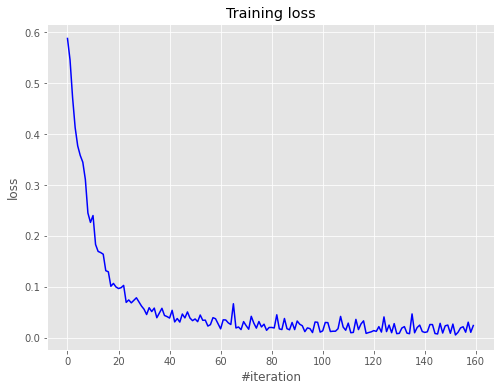

Current loss: 0.023940


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [12]:
np.round(predictions[:10],3)

array([[0.023, 0.977],
       [0.016, 0.984],
       [0.794, 0.206],
       [0.999, 0.001],
       [0.005, 0.995],
       [0.002, 0.998],
       [0.004, 0.996],
       [0.988, 0.012],
       [0.003, 0.997],
       [1.   , 0.   ]])

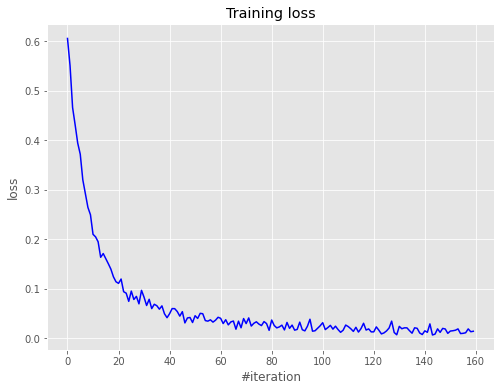

Current loss: 0.014213


In [8]:
# this is the original plot

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [1]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits['data'] / 255.0, digits['target']

One-hot encode the labels first.

In [2]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = enc.fit_transform(y.reshape(-1, 1)).todense()


print(one_hot_y.shape[0])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, one_hot_y, test_size = 0.2, random_state = 42)

1797


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [3]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

%run assignment1_modules.ipynb

def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1  
            
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx] 

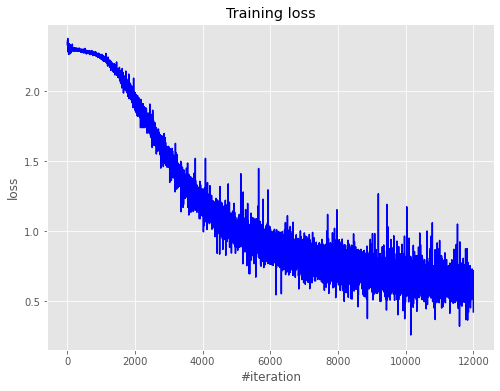

Current loss: 0.424673


In [7]:
# playing with all this stuff I found that these parameters are good
###### ReLU #######

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(ReLU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_ReLU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_ReLU.append(loss)
        y_pred_ReLU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_ReLU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [8]:
my_pred_ReLU = np.argmax(y_pred_ReLU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("ReLU accuracy:", accuracy_score(yy_test, my_pred_ReLU))

ReLU accuracy: 0.8333333333333334


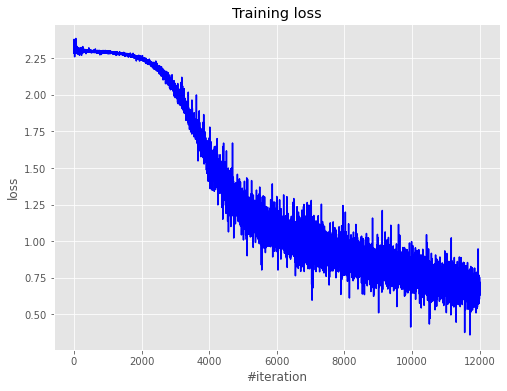

Current loss: 0.713502


In [9]:
###### ReLU with BatchMeanSubtraction #######

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(BatchMeanSubtraction())
net.add(ReLU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_BMS_ReLU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_BMS_ReLU.append(loss)
        y_pred_BMS_ReLU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_BMS_ReLU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [11]:
my_pred_BMS_ReLU = np.argmax(y_pred_BMS_ReLU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("ReLU accuracy:", accuracy_score(yy_test, my_pred_BMS_ReLU))

ReLU accuracy: 0.7666666666666667


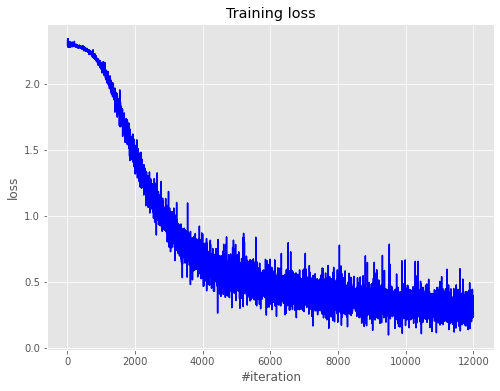

Current loss: 0.265677


In [139]:
### ELU ######

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(ELU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_ELU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_ELU.append(loss)
        y_pred_ELU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_ELU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [140]:
my_pred_ELU = np.argmax(y_pred_ELU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("ReLU accuracy:", accuracy_score(yy_test, my_pred_ELU))

ReLU accuracy: 0.9


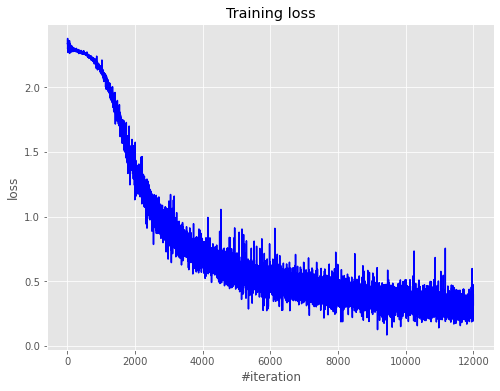

Current loss: 0.314912


In [141]:
###### ELU with BatchMeanSubtraction #######

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(BatchMeanSubtraction())
net.add(ELU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_BMS_ELU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_BMS_ELU.append(loss)
        y_pred_BMS_ELU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_BMS_ELU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [142]:
my_pred_BMS_ELU = np.argmax(y_pred_BMS_ELU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("ReLU accuracy:", accuracy_score(yy_test, my_pred_BMS_ELU))

ReLU accuracy: 0.8666666666666667


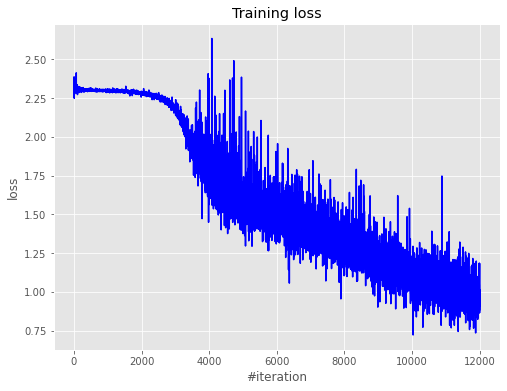

Current loss: 1.010793


In [27]:
##### LeakyReLU #####

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(LeakyReLU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_LeakyReLU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_LeakyReLU.append(loss)
        y_pred_LeakyReLU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_LeakyReLU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [28]:
my_pred_LeakyReLU = np.argmax(y_pred_LeakyReLU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("LeakyReLU accuracy:", accuracy_score(yy_test, my_pred_LeakyReLU))

LeakyReLU accuracy: 0.6611111111111111


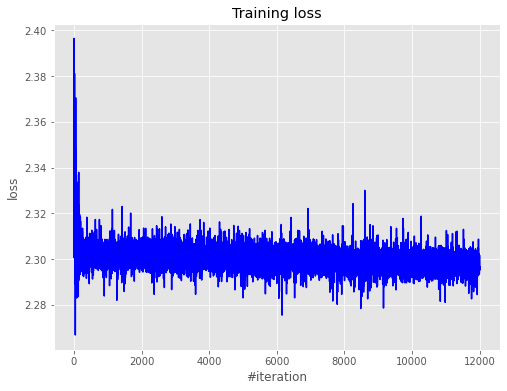

Current loss: 2.296605


In [24]:
##### LeakyReLU with BMS #####

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(BatchMeanSubtraction())
net.add(LeakyReLU())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_BMS_LeakyReLU = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_BMS_LeakyReLU.append(loss)
        y_pred_BMS_LeakyReLU = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_BMS_LeakyReLU, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [29]:
my_pred_BMS_LeakyReLU = np.argmax(y_pred_BMS_LeakyReLU, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("LeakyReLU with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_LeakyReLU))

LeakyReLU with BMS accuracy: 0.07777777777777778


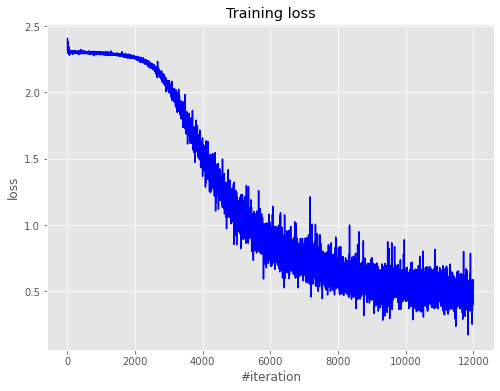

Current loss: 0.583043


In [30]:
##### SoftPlus #####

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(SoftPlus())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_SoftPlus = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_SoftPlus.append(loss)
        y_pred_SoftPlus = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_SoftPlus, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [31]:
my_pred_SoftPlus = np.argmax(y_pred_SoftPlus, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("SoftPlus accuracy:", accuracy_score(yy_test, my_pred_SoftPlus))

LeakyReLU accuracy: 0.8222222222222222


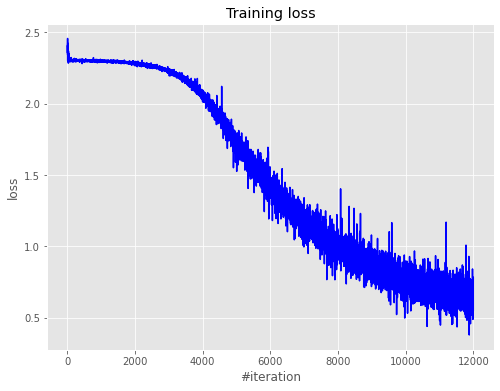

Current loss: 0.554721


In [32]:
##### SoftPlus with BMS #####

criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(X_train.shape[1], 4))
net.add(BatchMeanSubtraction())
net.add(SoftPlus())
net.add(Linear(4, y_train.shape[1]))
net.add(SoftMax())

# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 128

    
loss_history_BMS_SoftPlus = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history_BMS_SoftPlus.append(loss)
        y_pred_BMS_SoftPlus = net.forward(X_test)
        
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title('Training loss')
    plt.xlabel('#iteration')
    plt.ylabel('loss')
    plt.plot(loss_history_BMS_SoftPlus, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)  

In [34]:
my_pred_BMS_SoftPlus = np.argmax(y_pred_BMS_SoftPlus, axis = 1).reshape(-1,1)
yy_test = np.argmax(y_test, axis = 1)

from sklearn.metrics import accuracy_score

print("SoftPlus with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_SoftPlus))

SoftPlus with BMS accuracy: 0.8305555555555556


Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

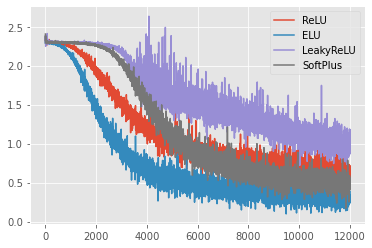

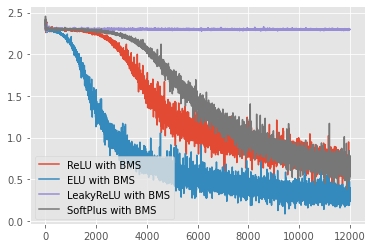

ReLU accuracy: 0.8333333333333334
ELU accuracy: 0.9
LeakyReLU accuracy: 0.6611111111111111
SoftPlus accuracy: 0.8222222222222222

ReLu with BMS accuracy: 0.7666666666666667
ELU with BMS accuracy: 0.8666666666666667
LeakyReLU with BMS accuracy: 0.07777777777777778
SoftPlus with BMS accuracy: 0.8305555555555556


In [200]:
# ok, what we have
plt.plot(loss_history_ReLU, label='ReLU')
plt.plot(loss_history_ELU, label='ELU') 
plt.plot(loss_history_LeakyReLU, label='LeakyReLU')
plt.plot(loss_history_SoftPlus, label='SoftPlus')

plt.legend()
plt.show()

plt.plot(loss_history_BMS_ReLU, label='ReLU with BMS')
plt.plot(loss_history_BMS_ELU, label='ELU with BMS') 
plt.plot(loss_history_BMS_LeakyReLU, label='LeakyReLU with BMS')
plt.plot(loss_history_BMS_SoftPlus, label='SoftPlus with BMS')

plt.legend()
plt.show()

print("ReLU accuracy:", accuracy_score(yy_test, my_pred_ReLU))
print("ELU accuracy:", accuracy_score(yy_test, my_pred_ELU))
print("LeakyReLU accuracy:", accuracy_score(yy_test, my_pred_LeakyReLU))
print("SoftPlus accuracy:", accuracy_score(yy_test, my_pred_SoftPlus))

print()
print("ReLu with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_ReLU))
print("ELU with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_ELU))
print("LeakyReLU with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_LeakyReLU))
print("SoftPlus with BMS accuracy:", accuracy_score(yy_test, my_pred_BMS_SoftPlus))

### Well, insights from my results:  
1. 90% accuracy with ELU, 80% + with ReLU and SoftPlus. So, I'm stopping here. In future, when will have free time - will play with dropout, learning rate etc.

2. BMS generally is not good for these models: it only improves {a bit} model with SoftPlus activation. For LeakyReLU probably there is some problem in my code.

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

Print here your accuracy. It should be around 90%.

In [156]:
print("My NN with ELU activation without BMS gives:", accuracy_score(yy_test, my_pred_ELU))

My NN with ELU activation without BMS gives: 0.9


# Autoencoder (optional) 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
![](https://multithreaded.stitchfix.com/assets/images/blog/PS_NN_graphic_colors2.png)

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction. Use **BatchMeanNormalization** between **Linear** and **ReLU**. You may not use nonlinearity in bottleneck layer.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [17]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [1]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################